In [4]:
try:
  # Try to mount drive when working on colab
  from google.colab import drive
except:
  # Do nothing in case of exception
  pass
else:
  # Clone and repository and install the deep_nn_odes module
  drive.mount('/content/drive',force_remount=True)
  !rm -rf deep_nn_odes
  !git clone https://github.com/eikehmueller/deep_nn_odes.git
  %cd deep_nn_odes
  !git checkout CNNs
  !python3 -m pip install .
  # Download CIFAR10 data and unpack it
  !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !mkdir data; tar xzvf cifar-10-python.tar.gz -C data
  # Change to src directory
  %cd src

import pickle
import json
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
from deep_nn_odes.image_dataset_loader import MNISTDatasetLoader, CIFAR10DatasetLoader
from deep_nn_odes.cnn_model import init_resnet_parameters, resnet_model

%matplotlib inline

In [5]:
def fit(model, params, optimizer, image_dataset_loader, batch_size=128, nepoch=10):
    """Fit the CNN classifier using cross-entropy loss

    :arg model: the model to fit
    :arg params: fit parameters
    :arg optimizer: optimizer
    :arg image_dataset_loader: loader for image dataset
    :arg batch_size: size of training batches
    :arg nepoch: number of epochs
    """
    from collections import defaultdict

    opt_state = optimizer.init(params)

    def accuracy(params, model_state, x, y):
        """Compute accuracy, i.e. fraction of correct predictions
        in a minibatch

        :arg params: model parameters
        :arg model: model
        :arg x: minibatch of input images
        :arg y: minibatch of labels
        """
        y_pred = model(params, model_state, x)
        n_total = y.shape[0]
        n_correct = jnp.sum(1 * (jnp.argmax(jax.nn.softmax(y_pred), axis=-1) == y))
        return n_correct / n_total

    def loss(params, model_state, x, y):
        """Cross-entropy loss function

        :arg params: model parameters
        :arg model: model
        :arg x: minibatch of input images
        :arg y: minibatch of labels
        """
        logits = model(params, model_state, x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

    @jax.jit
    def step(params, model_state, opt_state, X_batch, y_batch):
        """Single update step"""
        loss_value, grads = jax.value_and_grad(loss)(
            params, model_state, X_batch, y_batch
        )
        acc_value = accuracy(params, model_state, X_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, model_state, opt_state, loss_value, acc_value

    X_valid, y_valid = image_dataset_loader.get_validation_data()
    metrics = defaultdict(list)
    rngkey = jax.random.PRNGKey(seed=37)
    # CNN model state for training with dropout
    train_state = dict(rngkey=rngkey, train=True)
    # CNN model state for validation with dropout disabled
    valid_state = dict(rngkey=rngkey, train=False)
    # Loop over epochs
    for epoch in range(nepoch):
        acc_train = 0.0
        # iterate over all batches
        for n, (X_batch, y_batch) in enumerate(
            zip(*image_dataset_loader.get_shuffled_batched_train_data(batch_size))
        ):
            params, train_state, opt_state, loss_train, acc_batch = step(
                params, train_state, opt_state, X_batch, y_batch
            )
            # Update the rolling sum of the training accuracy
            acc_train += (acc_batch - acc_train) / (n + 1)
        # compute loss and accuracy on validation data
        loss_valid = loss(params, valid_state, X_valid, y_valid)
        acc_valid = accuracy(params, valid_state, X_valid, y_valid)
        print(f"**** epoch {(epoch+1):4d} of {nepoch:4d} ****")
        print(f"                loss = {loss_train:8.3e}  accuracy = {acc_train:8.3f}")
        print(f"     validation loss = {loss_valid:8.3e}  accuracy = {acc_valid:8.3f}")
        print("")
        # Update metrics
        metrics["loss_train"].append(float(loss_train))
        metrics["loss_valid"].append(float(loss_valid))
        metrics["acc_train"].append(float(acc_train))
        metrics["acc_valid"].append(float(acc_valid))
    return params, metrics


## Train network
Edit the hyperparameters in the following cell and run it to train with the `fit()` function defined in the previous cell.

In [ ]:
# batch size
batch_size = 128
# number of epochs
nepoch = 500
# Optimizer hyperparameters
learning_rate = 1.0e-3

dataset_loader = CIFAR10DatasetLoader(validation_split=0.1, normalise_images=True)
params = init_resnet_parameters(
    input_channels=dataset_loader.n_channels, n_categories=dataset_loader.n_categories
)
nparam = sum([x.size for x in jax.tree_util.tree_flatten(params)[0]])
print ("Number of model parameters = ",nparam)

optimizer = optax.adam(learning_rate)

params, metrics = fit(
    resnet_model, params, optimizer, dataset_loader, batch_size=batch_size, nepoch=nepoch
)

## Save the weights and training metrics
Edit the names of the filenames if you want to save under a different name.

In [ ]:
# Save weights and training metrics
with open("weights.npy", "wb") as f:
    pickle.dump(params, f)
with open("metrics.json", "w", encoding="utf8") as f:
    json.dump(metrics, f, indent=4)


## Visualise training metrics
The following cell will load the training metrics (loss and accuracy) from disk and visualise them as a function of the epoch. Edit the filename if you want to load the metrics from a different training run.

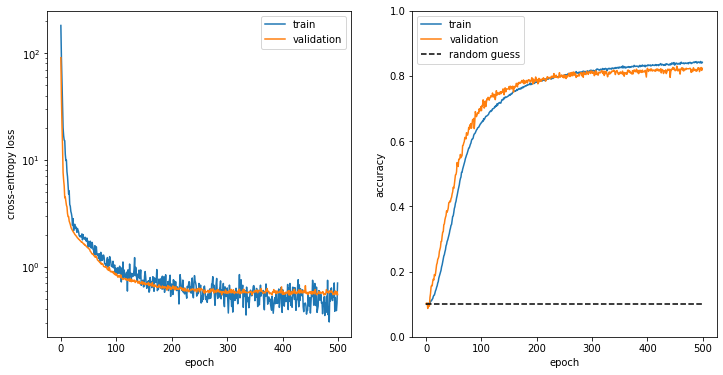

In [7]:
# Load metrics from disk
with open("metrics_19Dec2022.json","r",encoding="utf") as f:
    metrics = json.load(f)

fig, axs = plt.subplots(1,2,figsize=(12,6))
# loss
axs[0].plot(metrics["loss_train"],label="train")
axs[0].plot(metrics["loss_valid"],label="validation")
axs[0].set_yscale("log")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("cross-entropy loss")
axs[0].legend(loc="upper right")
axs[1].set_ylim(0,1)
axs[1].plot(metrics["acc_train"],label="train")
axs[1].plot(metrics["acc_valid"],label="validation")
axs[1].plot([0,len(metrics["acc_train"])],[0.1,0.1],color="black",linestyle="--",label="random guess")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper left")

## Evaluate network on test data
Compute the accuracy on the training dataset. To load the weights from a different file, edit the filename.

In [8]:
# Test model performance on test data
with open("weights_19Dec2022.npy", "rb") as f:
    params = pickle.load(f)

rngkey = jax.random.PRNGKey(seed=37)
test_state = dict(rngkey=rngkey, train=False)

test_images, test_labels = dataset_loader.get_test_data()
n_batch = 10 # Split into batches since the model does not fit into memory for the entire test data
n_total = 0
n_correct = 0
for images, labels in zip(jnp.split(test_images,n_batch),jnp.split(test_labels,n_batch)):
    y_pred = resnet_model(params, test_state, images)
    n_total += labels.shape[0]
    n_correct += jnp.sum(1 * (jnp.argmax(jax.nn.softmax(y_pred), axis=-1) == labels))
print (f"Test accuracy = {(100*n_correct/n_total):4.2f}%")

Test accuracy = 81.83%
